In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import linalg as LA
from scipy.fft import fft,fftfreq
import scipy

Setting a bunch of parameters first!

In [2]:
hbar = 1 *1e-34

def print_section():
    print("---------------------------------------------------------------------------------------------------------------------")
    return None
random.seed(42069) #Seed for reproducibility
T = 10 * 1e-3
kb = 1.38*1e-23
kappa = 0.248;
z0 = 3/4*2.7*1e-3;
r0 = 3/4*3.5*1e-3;
a1 = -0.001;
q1 = 0.15;#0.21801801801801804
omega_RF = 2*np.pi*5.2*1e6;
m1 = 135*1.66*(10**(-27))
m2 = 250*1.66*(10**(-27))
Q1 = 1*1.6*1e-19;
Q2 = 1*1.6*1e-19;
omega_z1 = omega_RF*np.sqrt(-a1/2)
omega_r1 = omega_RF/2*np.sqrt(q1**2/2+a1)
V_DC = 18#-a1*m1*(3/4*2.7*1e-3)**2*omega_RF**2/(4*Q1*0.248)
V_RF = 1000#q1/(2*Q1)*(m1*r0**2*omega_RF**2)
c = 3*1e8
lambd = c/(607.426262*1e12)
alpha = 0.1 #0.5 for radial degeneracy
waist = 500*1e-6
epsilon0 = 8.85*1e-12



Gamma = 2*np.pi*15.2*1e6
detuning = -Gamma/2
k = 2*np.pi/lambd*np.array([1/2,1/2,1/np.sqrt(2)])
saturation = 0.1


rho = Q2/Q1
mu = m2/m1

a2 = rho/mu * a1
q2 = rho/mu * q1

omega_z2 = omega_RF*np.sqrt(-a2/2)

omega_pond_1 = Q1*V_RF/(np.sqrt(2)*omega_RF*m1*r0**2)
omega_x1 = np.sqrt(omega_pond_1**2 - alpha*omega_z1**2)
omega_y1 = np.sqrt(omega_pond_1**2-(1-alpha)*omega_z1**2)

omega_pond2 = Q2*V_RF/(np.sqrt(2)*omega_RF*m2*r0**2)
omega_x2 = np.sqrt(omega_pond2**2-alpha*omega_z2**2)
omega_y2 = np.sqrt(omega_pond2**2-(1-alpha)*omega_z2**2)

zeq1 = np.cbrt(Q1*Q2/(4*np.pi*epsilon0*m1*omega_z1**2)*(1/(1+1/rho)**2))
zeq2 = -1/rho * zeq1
V_tickle = 0.5*V_DC
print_section()
print("DC Voltage: ",V_DC)
print("RF Voltage: ", V_RF )
print("Tickle Voltage: ", V_tickle)
print_section()
print("Equilibrium positions (µm): " , "z1 = ", zeq1 * 1e6, "    z2 = " ,zeq2 * 1e6)

---------------------------------------------------------------------------------------------------------------------
DC Voltage:  18
RF Voltage:  1000
Tickle Voltage:  9.0
---------------------------------------------------------------------------------------------------------------------
Equilibrium positions (µm):  z1 =  7.835791138998222     z2 =  -7.835791138998222


Now solve the 2nd order eigenproblem!

In [3]:
deltaZ = zeq1-zeq2
K11 = omega_z1**2 + Q1*Q2/(4*np.pi*epsilon0*m1) * (2/deltaZ**3)
K12 = -Q1*Q2/(4*np.pi*epsilon0*np.sqrt(m1*m2)) * (2/deltaZ**3)
K22 = omega_z2**2 + Q1*Q2/(4*np.pi*epsilon0*m2) * (2/deltaZ**3)

K33 = omega_x1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K34 = -0.5*K12
K44 = omega_x2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

K55 = omega_y1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K56 = K34
K66 = omega_y2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

KZ = np.array([[K11,K12],[K12,K22]])
KY = np.array([[K33,K34],[K34,K44]])
KX = np.array([[K55,K56],[K56,K66]])


z_freqs, z_vecs = LA.eig(KZ)
y_freqs, y_vecs = LA.eig(KY)
x_freqs, x_vecs = LA.eig(KX)

z_freqs = np.sqrt(z_freqs)
y_freqs = np.sqrt(y_freqs)
x_freqs = np.sqrt(x_freqs)

print_section()
print("z frequencies are (kHz) : ", (z_freqs[0])/(2*np.pi*1e3),"     ", (z_freqs[1])/(2*np.pi*1e3))
print("z eigenvectors are: ", z_vecs[:,0], "        ", z_vecs[:,1])
print_section()
print("x frequencies are (kHz) : ", (x_freqs[0])/(2*np.pi*1e3),"     ", (x_freqs[1])/(1*np.pi*1e3))
print("x eigenvectors are: ", x_vecs[:,0], "        ", x_vecs[:,1])
print_section()
print("y frequencies are (kHz) : ", (y_freqs[0])/(2*np.pi*1e3),"     ", (y_freqs[1])/(1*np.pi*1e3))
print("y eigenvectors are: ", y_vecs[:,0], "        ", y_vecs[:,1])
print_section()

#Remember to include z-tickle in radial direction as well.

---------------------------------------------------------------------------------------------------------------------
z frequencies are (kHz) :  180.39386366047964       95.39210634871365
z eigenvectors are:  [ 0.87481329 -0.48446023]          [0.48446023 0.87481329]
---------------------------------------------------------------------------------------------------------------------
x frequencies are (kHz) :  329.76989167912024       326.3111638901716
x eigenvectors are:  [0.99816233 0.06059668]          [-0.06059668  0.99816233]
---------------------------------------------------------------------------------------------------------------------
y frequencies are (kHz) :  345.7556250874058       360.43092596676917
y eigenvectors are:  [0.99836581 0.05714637]          [-0.05714637  0.99836581]
---------------------------------------------------------------------------------------------------------------------


Now we write a function for calculating the force a charged particle feels in the trap!

In [4]:
def TrapForce(q,r,V_DC,V_RF,alpha,t):
    #r is 3d vector (x,y,z)
    z = r[2]
    x = r[0]
    y = r[1]
    Fz = -q*2*kappa*V_DC/(z0**2) * z
    Fy = q*(2*(1-alpha)*kappa*V_DC/(z0**2) *y -V_RF/(r0**2)*y*np.cos(omega_RF*t))
    Fx = q*(2*alpha*kappa*V_DC/(z0**2) *x +V_RF/(r0**2)*x*np.cos(omega_RF*t))
    return  np.array([Fx,Fy,Fz])

Everything is in place. Let us do a simple velocity-verlet integration to check everything works.

In [7]:
r_init = np.array([-np.sqrt(2*kb*T/(m1*omega_x1**2)),np.sqrt(2*kb*T/(m1*omega_y1**2)),np.sqrt(2*kb*T/(m1*omega_z1**2))])
v_init = np.zeros(3)
t_init = 0
t_end = 0.1*1e-3

dt = 2*np.pi/(omega_RF)/360

t = 0
ts = []
positions = []
velocities = []
print("Initial Time: ", t_init)
print("End Time: ", t_end)
print("Time Step: ", dt)
print("Total number of steps: ",np.floor(t_end/dt))
print_section()
print("Initial position (µm): ", r_init*1e6)
print("Initial velcoity (m/s): ", v_init)

print_section()
print("Secular z-direction Barium Frequency (kHz):  ", omega_z1/(2*np.pi*1e3))
print("Secular x-direction Barium Frequency (kHz):  ", omega_y1/(2*np.pi*1e3))
print("Secular y-direction Barium Frequency (kHz):  ", omega_x1/(2*np.pi*1e3))
print_section()


Initial Time:  0
End Time:  0.0001
Time Step:  5.341880341880342e-10
Total number of steps:  187200.0
---------------------------------------------------------------------------------------------------------------------
Initial position (µm):  [-0.49754173  0.52037335  1.51902667]
Initial velcoity (m/s):  [0. 0. 0.]
---------------------------------------------------------------------------------------------------------------------
Secular z-direction Barium Frequency (kHz):   116.27553482998908
Secular x-direction Barium Frequency (kHz):   339.4209912551956
Secular y-direction Barium Frequency (kHz):   354.99663280749525
---------------------------------------------------------------------------------------------------------------------


In [8]:
current_pos = r_init
current_vel = v_init
counter = 0
while t < t_end:
    next_t = t+dt
    next_pos = current_pos+current_vel*dt+1/(m1*2)*TrapForce(Q1,current_pos,V_DC,V_RF,alpha,t)*dt**2
    next_force = TrapForce(Q1,next_pos,V_DC,V_RF,alpha,next_t)
    next_vel = current_vel+1/(2*m1)*(TrapForce(Q1,current_pos,V_DC,V_RF,alpha,t)+next_force)*dt
    
    if np.mod(counter,500) == 0:
        ts.append(t)
        positions.append(current_pos)
        velocities.append(current_vel)

    t+=dt
    current_pos=next_pos
    current_vel=next_vel
    counter +=1

3.744


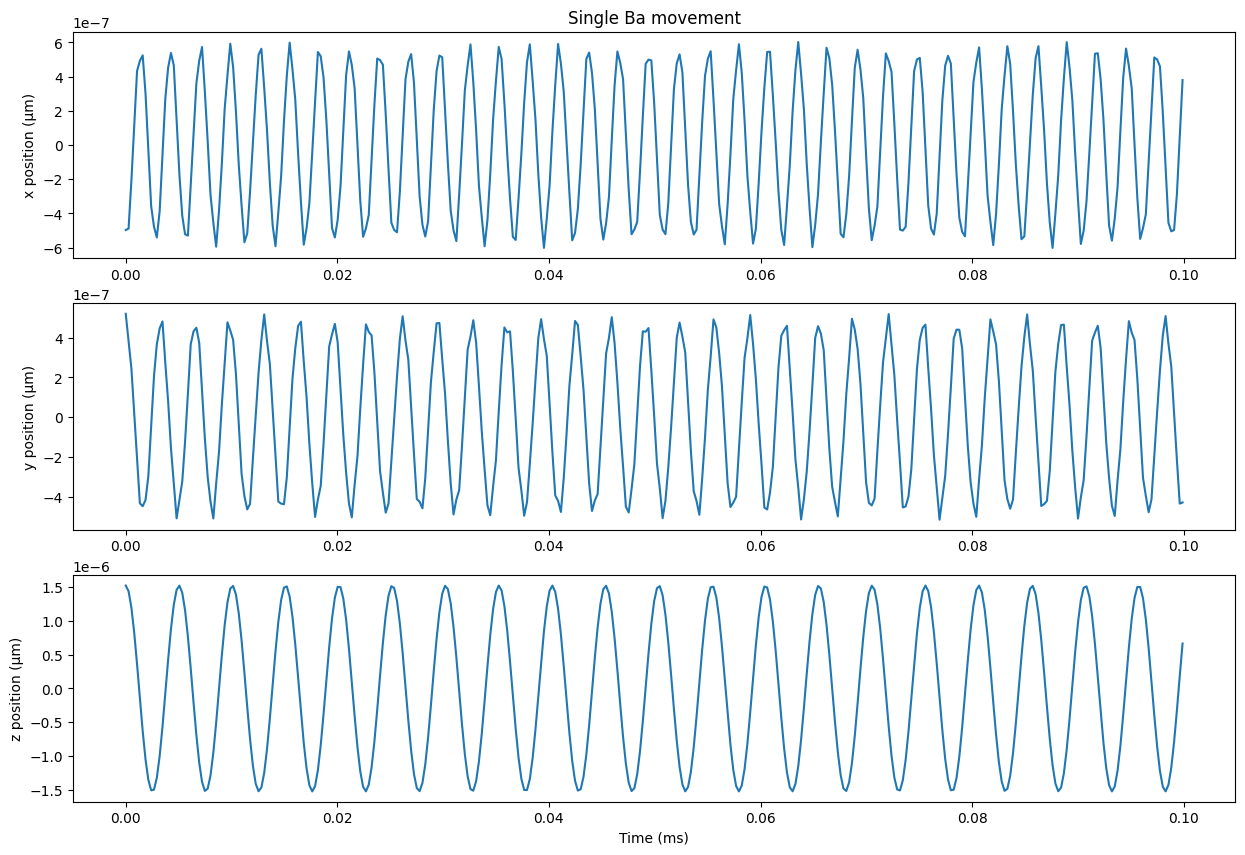

In [9]:
fig,ax = plt.subplots(3,1,figsize = (15,10))
zs = []
ys = []
xs = []
for position in positions:
    zs.append(position[2])
    ys.append(position[1])
    xs.append(position[0])

ax[0].plot(np.array(ts)*1e3,xs)
ax[1].plot(np.array(ts)*1e3,ys)
ax[2].plot(np.array(ts)*1e3,zs)

ax[0].set_ylabel('x position (µm)')
ax[1].set_ylabel('y position (µm)')
ax[2].set_ylabel('z position (µm)')
ax[0].set_title('Single Ba movement')
ax[2].set_xlabel('Time (ms)')
print(1/(500*dt)*1e-6)

Let's do an FFT of above just to be entirely sure!

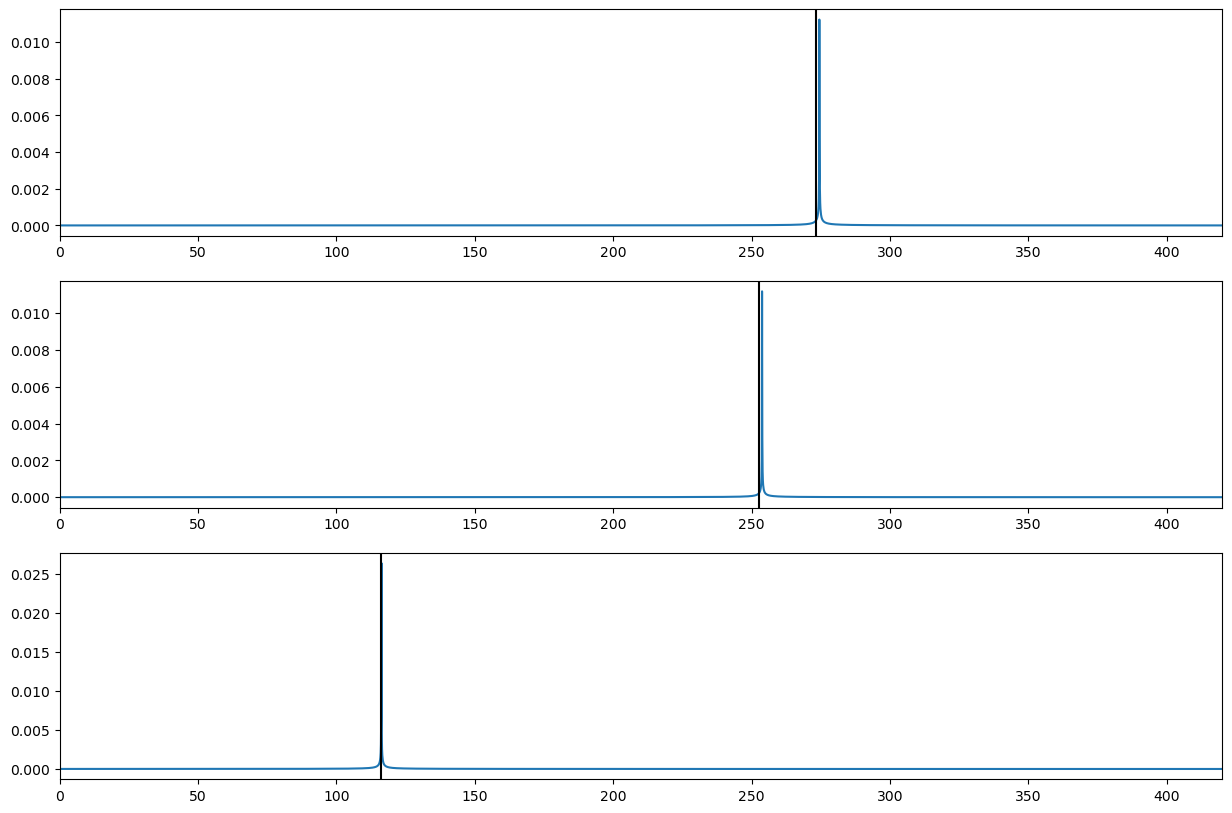

In [ ]:
zfft = fft(zs)
yfft = fft(ys)
xfft = fft(xs)
tfft = fftfreq(len(ts),np.diff(ts)[0])
fftfig,fftax = plt.subplots(3,1,figsize = (15,10))


examp = np.sin(omega_z1*np.array(ts))
fftexamp= fft(examp)
fftax[0].plot(tfft[:len(ts)//2]/1e3,np.abs(xfft)[0:len(ts)//2])
fftax[0].set_xlim(0,420)
fftax[0].axvline(omega_x1/(2*np.pi*1e3),color = 'k')

fftax[1].plot(tfft[:len(ts)//2]/1e3,np.abs(yfft)[0:len(ts)//2])
fftax[1].set_xlim(0,420)
fftax[1].axvline(omega_y1/(2*np.pi*1e3),color = 'k')

fftax[2].plot(tfft[:len(ts)//2]/1e3,np.abs(zfft)[0:len(ts)//2])
fftax[2].set_xlim(0,420)
fftax[2].axvline(omega_z1/(2*np.pi*1e3),color = 'k')


Radial results seem to be a few kHz off. While the radial potential is only solved approximately with the pseudopotential approximation, I am unclear if this deviation of approx 1% is due to error or simply comes from approximation. Below we calculate their individual offsets in kHz

In [ ]:
Xpeak = scipy.signal.find_peaks(np.abs(xfft)[tfft/1e3>250])
Ypeak =scipy.signal.find_peaks(np.abs(yfft)[tfft/1e3>250])
xind = Xpeak [0][0]
yind = Ypeak [0][0]
print(tfft[tfft/1e3>250][xind]/1e3-omega_x1/(1e3*2*np.pi))
print(tfft[tfft/1e3>250][yind]/1e3-omega_y1/(1e3*2*np.pi))

1.1833199238786278
1.0443340969929977


Both seem to be offset by 3.5-3.7kHz, which is certainly curios that the offsets are near-identical. For now I won't worry about this too much. But definitely something to look into.
Moving on to implementing laser cooling! First we make a function to draw a random unit vector in 3D!

<Figure size 640x480 with 0 Axes>

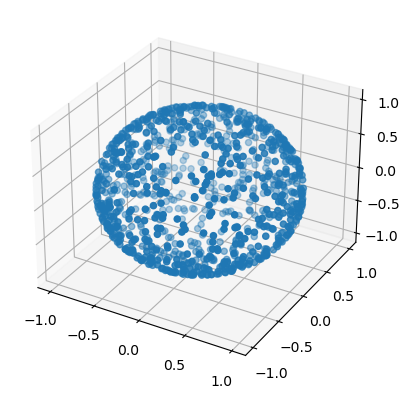

In [ ]:
def random_direction():
    u,v = np.random.rand(2)
    phi = 2*np.pi*u
    theta = np.arccos(1-2*v)
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
x3d = []
y3d = []
z3d = []

for j in range(1000):
    direction = random_direction()
    x3d.append(direction[0])
    y3d.append(direction[1])
    z3d.append(direction[2])
fig3D = plt.figure()
ax3D =plt.figure().add_subplot(projection='3d')
ax3D.scatter(x3d,y3d,z3d)

We seem to be correctly sampling the 3D space unformly! We're ready for cooling, which is implemented via a stochastic model.

In [ ]:
current_pos = r_init
current_vel = v_init
counter = 0
current_state = 0
t= 0
ts = []
positions = []
velocities = []
states = []
k_norm = LA.norm(k)
print_section()
print("Starting cooling, 1 ion run")
print("Starting time: ",t)
print("Start counter: ", counter)
print("Start position (um): ",current_pos*1e6)
print("Start velocity (m/s): ",current_vel)
print("Current state: ",current_state)
print_section
while t < t_end:
    next_t = t+dt
    next_pos = current_pos+current_vel*dt+1/(m1*2)*TrapForce(Q1,current_pos,V_DC,V_RF,alpha,t)*dt**2
    next_force = TrapForce(Q1,next_pos,V_DC,V_RF,alpha,next_t)
    next_vel = current_vel+1/(2*m1)*(TrapForce(Q1,current_pos,V_DC,V_RF,alpha,t)+next_force)*dt

    if current_state == 0:
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel))**2/(Gamma**2))
        rnd_nr = np.random.rand()
        if rnd_nr < B12*dt: #Absorption
            next_vel += hbar*k/m1
            current_state = 1
    elif current_state ==1: #Technically this oculd just be else, but the elif is nice if we want to expand to more than two levels
        rnd_nr = np.random.rand()
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel))**2/(Gamma**2))
        
        if rnd_nr < Gamma* dt: #Spontaneous emission
            next_vel += hbar/m1*k_norm*random_direction()
            current_state = 0
        elif rnd_nr < (B12+Gamma)*dt: #Stimulated emission
            next_vel -= hbar/m1*k
            current_state = 0


    if np.mod(counter,500) == 0:
        ts.append(t)
        positions.append(current_pos)
        velocities.append(current_vel)
        states.append(current_state)
    t+=dt
    current_pos=next_pos
    current_vel=next_vel
    counter +=1


---------------------------------------------------------------------------------------------------------------------
Starting cooling, 1 ion run
Starting time:  0
Start counter:  0
Start position (um):  [-0.64624807  0.69881866  1.51902667]
Start velocity (m/s):  [0. 0. 0.]
Current state:  0


Let's try to plot the results!

Text(0, 0.5, 'Internal State')

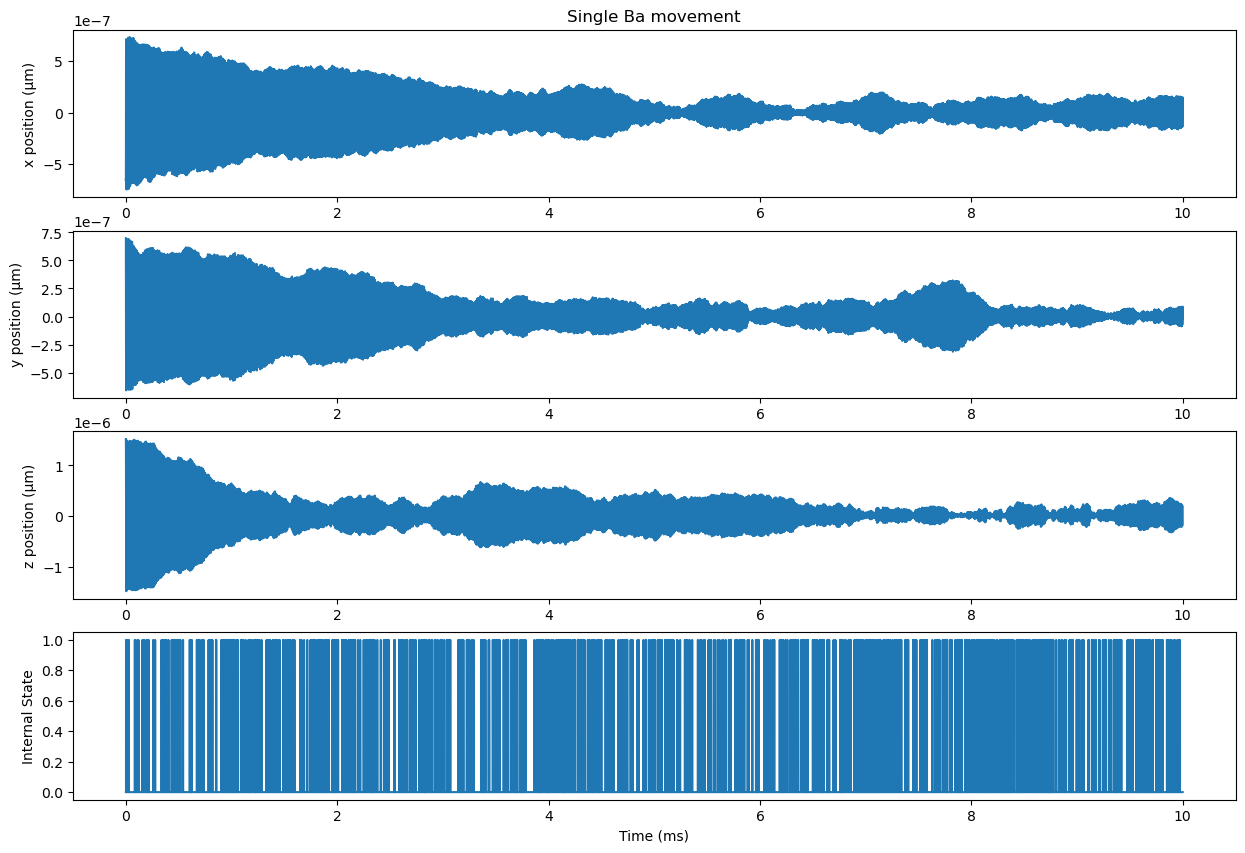

In [ ]:
fig,ax = plt.subplots(4,1,figsize = (15,10))
zs = []
ys = []
xs = []
for position in positions:
    zs.append(position[2])
    ys.append(position[1])
    xs.append(position[0])

ax[0].plot(np.array(ts)*1e3,xs)
ax[1].plot(np.array(ts)*1e3,ys)
ax[2].plot(np.array(ts)*1e3,zs)
ax[3].plot(np.array(ts)*1e3,states)
ax[0].set_ylabel('x position (µm)')
ax[1].set_ylabel('y position (µm)')
ax[2].set_ylabel('z position (µm)')
ax[0].set_title('Single Ba movement')
ax[3].set_xlabel('Time (ms)')
ax[3].set_ylabel('Internal State')

Let's try to convert this into some kind of temperature. We find the kinetic energy of each direction and set it equal to $1/2 k_bT$

Text(0, 0.5, 'Total Temperature (mK)')

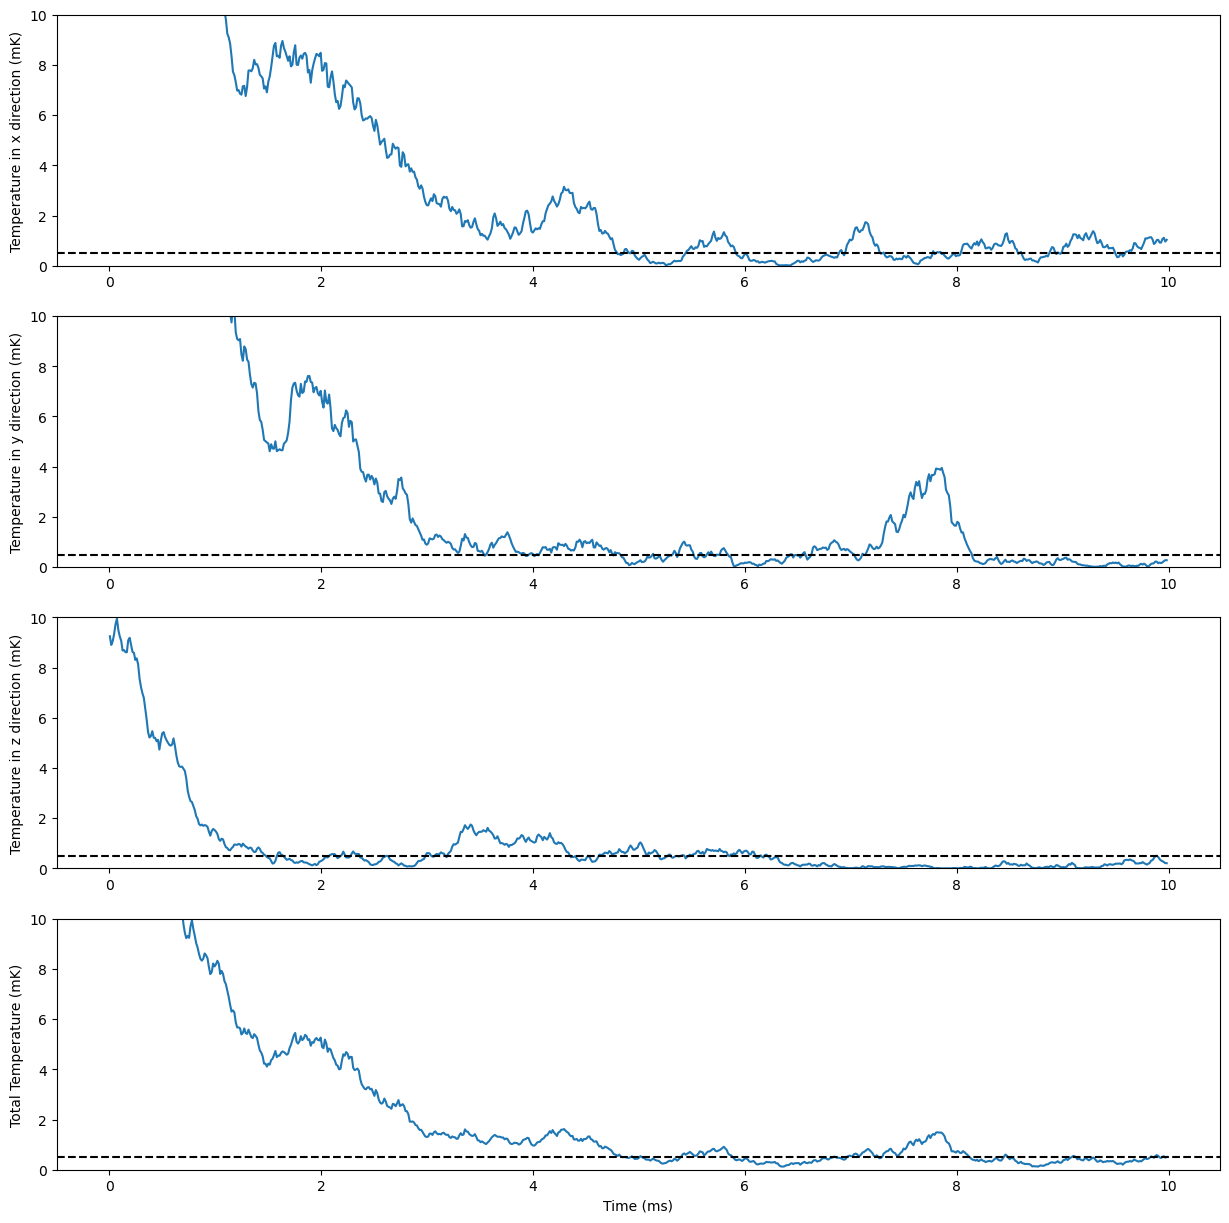

In [ ]:
fig,ax = plt.subplots(4,1,figsize = (15,15))

interval_length = 50


vxsq = []
vysq = []
vzsq = []
vsq = []
for velocity in velocities:
    vxsq.append(velocity[0]**2)
    vysq.append(velocity[1]**2)
    vzsq.append(velocity[2]**2)
    vsq.append(np.dot(velocity,velocity))
vxs = np.array(vxsq)
vys = np.array(vysq)
vzs = np.array(vzsq)
vsq = np.array(vsq)

vxsq_mean = []
vysq_mean = []
vzsq_mean = []
vsq_mean = []
t_mean = []
for j in range(int(np.floor(len(vxs)/interval_length))):
    vxsq_mean.append(np.sum(vxsq[interval_length*j : interval_length*(j+1)])/interval_length)
    vysq_mean.append(np.sum(vysq[interval_length*j : interval_length*(j+1)])/interval_length)
    vzsq_mean.append(np.sum(vzsq[interval_length*j : interval_length*(j+1)])/interval_length)
    vsq_mean.append(np.sum(vsq[interval_length*j : interval_length*(j+1)])/interval_length)
    t_mean.append(np.sum(ts[interval_length*j : interval_length*(j+1)])/interval_length)

vxsq_mean = np.array(vxsq_mean)
vysq_mean = np.array(vysq_mean)
vzsq_mean = np.array(vzsq_mean)
t_mean = np.array(t_mean)
vsq_mean = np.array(vsq_mean)



ax[0].plot(t_mean*1e3,m1*vxsq_mean/kb*1e3)
ax[1].plot(t_mean*1e3,m1*vysq_mean/kb*1e3)
ax[2].plot(t_mean*1e3,m1*vzsq_mean/kb*1e3)
ax[0].axhline(0.5,color = 'k',ls = '--')
ax[1].axhline(0.5,color = 'k',ls = '--')
ax[2].axhline(0.5,color = 'k',ls = '--')
ax[3].plot(t_mean*1e3,1/3*m1*vsq_mean/kb*1e3)
ax[3].axhline(0.5,color = 'k',ls = '--')

ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)

ax[3].set_xlabel('Time (ms)')

ax[0].set_ylabel('Temperature in x direction (mK)')
ax[1].set_ylabel('Temperature in y direction (mK)')
ax[2].set_ylabel('Temperature in z direction (mK)')
ax[3].set_ylabel('Total Temperature (mK)')

Cooling seems to be working incredibly well! As we more or less seem to be hitting exactly the doppler temperature, which is approx 0.5mK. We now want to add a 2nd ion, and just see the 2-ion dynamics first. This is done in a 2nd notebook (to save memory).